#### To Do

1. Sanity check first
1. Band power with respect to stimulus onset -> to check if LFP is properly aligned
2. Calculate hidden state distribution for each stimulus

#### Libraries and dependencies

In [1]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from copy import deepcopy
from numpy.fft import fft, ifft
from scipy.stats import zscore, mode
from matplotlib import pyplot as plt
from scipy.signal import butter, sosfiltfilt, filtfilt, hilbert
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
output_dir = "E:/jerry/vbn_s3_cache"
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)
probes = cache.get_probe_table() # type: ignore

e:\jerry\anaconda\envs\allensdk\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 1064644573 day 1

In [2]:
session_id = probes.loc[1064735073]['ecephys_session_id']
session = cache.get_ecephys_session(ecephys_session_id=session_id) # type: ignore
probeA = session.get_lfp(1064735071) #VISam
"""probeB = session.get_lfp(1064735072) #VISpm
probeC = session.get_lfp(1064735073) #VISp
probeD = session.get_lfp(1064735075) #VISl
probeE = session.get_lfp(1064735076) #VISal
probeF = session.get_lfp(1064735077) #VISrl""";
chans = session.get_channels()

#### 1055403683 day2

In [2]:
session = cache.get_ecephys_session(ecephys_session_id=1055403683)
chans = session.get_channels()

In [3]:
probeC = session.get_lfp(1055529307) #VISp
"""probeA = session.get_lfp(1055529304) #VISam
probeB = session.get_lfp(1055529306) #VISpm
probeD = session.get_lfp(1055529308) #VISl
probeE = session.get_lfp(1055529309) #VISal
probeF = session.get_lfp(1055529310) #VISrl""";


probe_probeC_lfp.nwb: 100%|██████████| 4.73G/4.73G [13:35<00:00, 5.81MMB/s]


In [6]:
# getting the start and end of stim block 0
stim_pre = session.stimulus_presentations
stim = stim_pre[stim_pre['stimulus_name'].str.contains('Natural')]
stim = stim[stim['stimulus_block'] == 0]
stim_times = stim.start_time.values # all the start times
stim_ids = stim.index.values # all the stimulus ids
start = stim.iloc[0].start_time
end = stim.iloc[-1].end_time
master_time = np.arange(start, end, 1/1250) # start to end sliced by 0.8ms <- sampling rate of LFP
imgs = np.unique(stim['image_name'].values)

In [7]:
print(imgs)

['im005_r' 'im024_r' 'im034_r' 'im083_r' 'im087_r' 'im104_r' 'im111_r'
 'im114_r' 'omitted']


In [22]:
img = imgs[3]
print(img)
stim_img = stim[stim['image_name'] == img]
stim_start = stim_img.start_time.values[:200]

im083_r


#### [Tutorial] Aligning LFP

In [40]:
def align_lfp(lfp, trial_window, alignment_times, trial_ids = None):
    '''
    Aligns the LFP data array to experiment times of interest
    INPUTS:
        lfp: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([trial_window + t for t in alignment_times])
    #print(time_selection)
    if trial_ids is None:
        trial_ids = np.arange(len(alignment_times))
        
    inds = pd.MultiIndex.from_product((trial_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))

    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
    ds = ds.assign(time=inds).unstack('time')

    return ds['aligned_lfp']

In [41]:
aligned_lfp = align_lfp(probeB, np.arange(-0.2, 0.2, 1/10), [stim_times[0]], [stim_ids[0]])

In [42]:
chans = session.get_channels()
lfp_chan_depths = [chans.loc[c]['probe_vertical_position'] for c in lfp.channel.values]

chans_in_brain = chans[(chans['probe_id']==1064735073)&(~chans['structure_acronym'].str.contains('root'))]
first_channel_in_brain_position = chans_in_brain['probe_vertical_position'].max()
fig, ax = plt.subplots()
fig.suptitle('Flash aligned mean LFP')
im = ax.pcolor(aligned_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_lfp.mean(dim='presentation_id').data)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Time from flash onset (s)')
_ = plt.ylabel('Channel Position from Tip (um)')

ax.axvline(0, c='w', ls='dotted')
ax.axvline(0.25, c='w', ls='dotted')
ax.axhline(first_channel_in_brain_position, c='w')
ax.text(-0.4, first_channel_in_brain_position+50, 'brain surface', c='w')

NameError: name 'lfp' is not defined

#### Filtering

In [11]:
def find_nearest_idx(array, value):
    if type(value) == np.ndarray:
        a = np.repeat(np.reshape(array, (1,-1)), len(value), axis=0)
        idx = np.argmin(np.abs(a - np.reshape(value, (-1,1))), axis=1)
        return idx
    else:
        return np.argmin(np.abs(array - value))

In [9]:
hit_rate = np.load('E:/jerry/hit_rates/1055403683.npz')
print(hit_rate['h_r'])

[0.58333333 0.71428571 0.7027027  0.         0.79411765 0.82352941
 0.14285714 0.88888889]


In [13]:
#lfpA_slice = probeA.sel(time=master_time, method='nearest')
#lfpB_slice = probeB.sel(time=master_time, method='nearest')
lfpC_slice = probeC.sel(time=master_time, method='nearest')
#lfpD_slice = probeD.sel(time=master_time, method='nearest')
#lfpE_slice = probeE.sel(time=master_time, method='nearest')
#lfpF_slice = probeF.sel(time=master_time, method='nearest')
#lfpA_copy = deepcopy(lfpA_slice)
#lfpB_copy = deepcopy(lfpB_slice)
lfpC_copy = deepcopy(lfpC_slice)
#lfpD_copy = deepcopy(lfpD_slice)
#lfpE_copy = deepcopy(lfpE_slice)
#lfpF_copy = deepcopy(lfpF_slice)

In [18]:
def testing(probe, num):
    ac47 = probe[:,num]
    bands = np.zeros((4, 200, 1250))
    Wns = [[3,8],[10,30],[30,50],[50,80]]
    for i, Wn in enumerate(Wns):
        sos = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='sos')
        for j, start in enumerate(stim_start):
            test = ac47.sel(time=slice(start-0.25, start+0.75)).values
            test_ff = sosfiltfilt(sos, test) 
            test_env = hilbert(test_ff)
            test_env_abs = np.abs(test_env)
            if len(test_env_abs) < 1250:
                bands[i][j][:len(test_env_abs)] = zscore(test_env_abs**2)
                bands[i][j][len(test_env_abs):] = zscore(test_env_abs[-1]**2)
            elif len(test_env_abs) > 1250:
                bands[i][j] = zscore(test_env_abs[:1250]**2)
            else:
                bands[i][j] = zscore(test_env_abs**2)
    avg = np.mean(bands, axis=1)
    plt.plot(avg[0].T, label='3-8')
    plt.plot(avg[1].T, label='10-30')
    plt.plot(avg[2].T, label='30-50')
    plt.plot(avg[3].T, label='50-80')
    plt.axvline(250/0.8, c='r')
    plt.axvline(500/0.8, c='r')
    plt.legend();
    return avg

##### find nearest idx

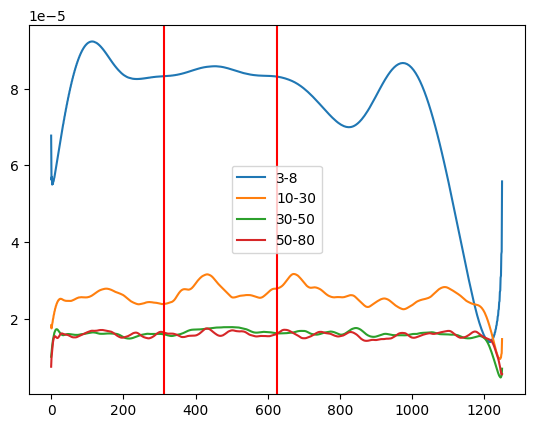

In [162]:
ac47=probeA[:,23]
bands = np.zeros((4, 200, 1250)) # 4 bands, 200 trials, 1250 time points
Wns = [[3,8],[10,30],[30,50],[50,80]]
for i, Wn in enumerate(Wns):
    sos = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='sos')
    for j, start in enumerate(stim_start):
        idx = np.arange(find_nearest_idx(ac47.time.values, start-0.25),find_nearest_idx(ac47.time.values, start+0.75))
        test = ac47.values[idx]
        test_ff = sosfiltfilt(sos, test) 
        test_env = hilbert(test_ff)
        test_env_abs = np.abs(test_env)
        if len(test_env_abs) < 1250:
            bands[i][j][:len(test_env_abs)] = test_env_abs
            bands[i][j][len(test_env_abs):] = test_env_abs[-1]
        elif len(test_env_abs) > 1250:
            bands[i][j] = test_env_abs[:1250]
        else:
            bands[i][j] = test_env_abs
avg = np.mean(bands, axis=1)
plt.plot(avg[0].T, label='3-8')
plt.plot(avg[1].T, label='10-30')
plt.plot(avg[2].T, label='30-50')
plt.plot(avg[3].T, label='50-80')
plt.axvline(250/0.8, c='r')
plt.axvline(500/0.8, c='r')
plt.legend()

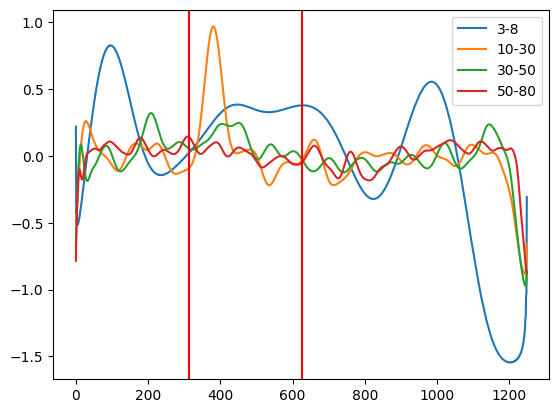

In [23]:
shared = testing(probeC, 23)

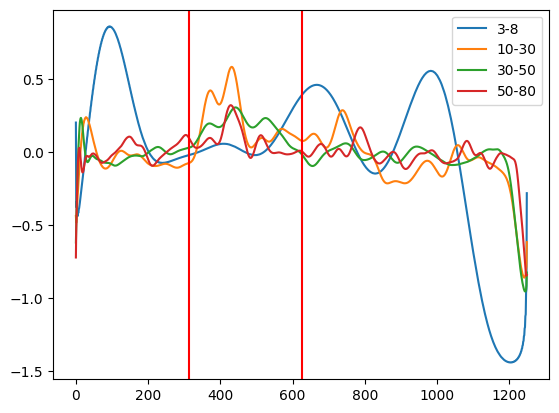

In [19]:
novel = testing(probeC, 23)

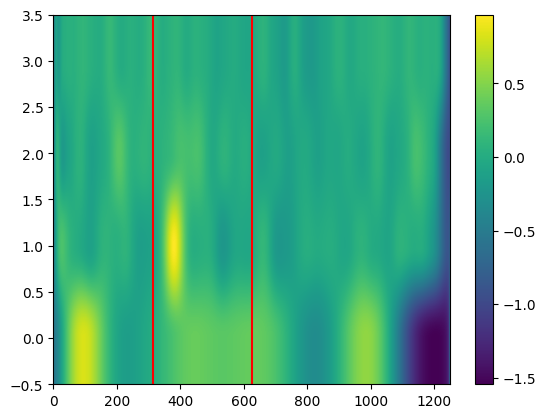

In [24]:
fig, ax = plt.subplots()
a = ax.imshow(shared, aspect='auto')
ax.axvline(250/0.8, c='r')
ax.axvline(500/0.8, c='r')
ax.invert_yaxis()
fig.colorbar(a)

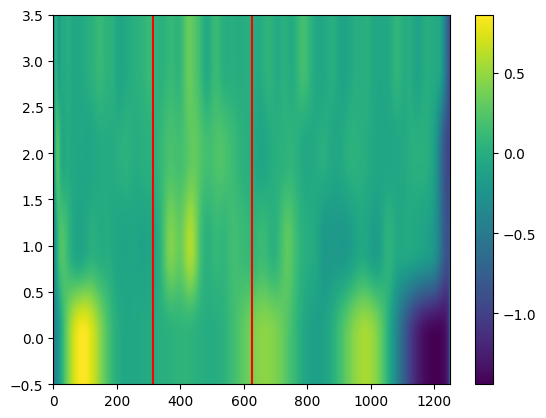

In [21]:
fig, ax = plt.subplots()
a = ax.imshow(novel, aspect='auto')
ax.axvline(250/0.8, c='r')
ax.axvline(500/0.8, c='r')
ax.invert_yaxis()
fig.colorbar(a)

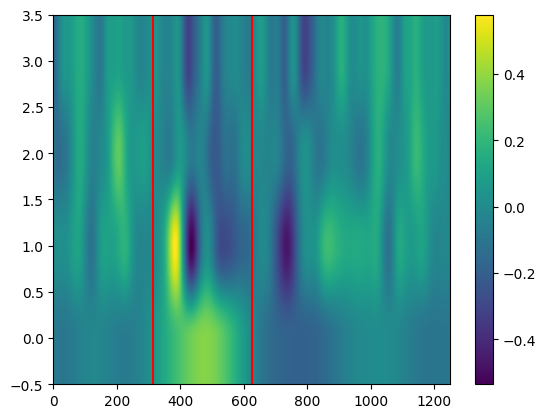

In [26]:
fig, ax = plt.subplots()
a = ax.imshow(shared-novel, aspect='auto')
ax.axvline(250/0.8, c='r')
ax.axvline(500/0.8, c='r')
ax.invert_yaxis()
fig.colorbar(a)

##### sel and slice

In [393]:
mask = np.array([46]) # channel 46
A_single = lfpA_copy[:,mask]
B_single = lfpB_copy[:,mask]
C_single = lfpC_copy[:,mask]
D_single = lfpD_copy[:,mask]
E_single = lfpE_copy[:,mask]
F_single = lfpF_copy[:,mask]

In [394]:
print(A_single.shape == B_single.shape == C_single.shape == D_single.shape == E_single.shape == F_single.shape) # should all be the same

True


#### GaussianHMM

In [395]:
# plotting state
def plot(preds, num=3):
    plt.plot(preds[0:int(750*num/0.8)])
    start_time = 0
    for i in range(num):
        plt.axvspan(start_time/0.8, (start_time+250)/0.8, alpha=0.2, color='red') # stimulus
        start_time += 250
        plt.axvspan(start_time/0.8, (start_time+500)/0.8, alpha=0.2, color='gray') # gray
        start_time += 500

In [ ]:
# archived
"""bands = np.zeros((4, 6, len(A_single))) # 4 bands, 6 channels, 400k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
all_channels = np.hstack((A_single, B_single, C_single, D_single, E_single, F_single))
print(all_channels.shape)
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    b, a = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='ba') # butterworth
    all_channels_ff = filtfilt(b, a, all_channels.T) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env) # no z-score here
    all_channels_env_abs_z = all_channels_env_abs
    bands[i] = all_channels_env_abs_z"""

In [417]:
bands = np.zeros((4, 6, len(A_single))) # 4 bands, 6 channels, 400k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
all_channels = np.hstack((A_single, B_single, C_single, D_single, E_single, F_single))
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, all_channels.T) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env)
    bands[i] = all_channels_env_abs

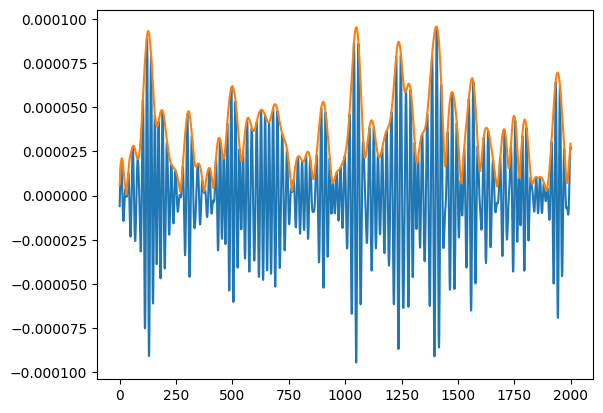

In [430]:
plt.plot(all_channels_ff[0,0:2000])
plt.plot(all_channels_env_abs[0,0:2000])

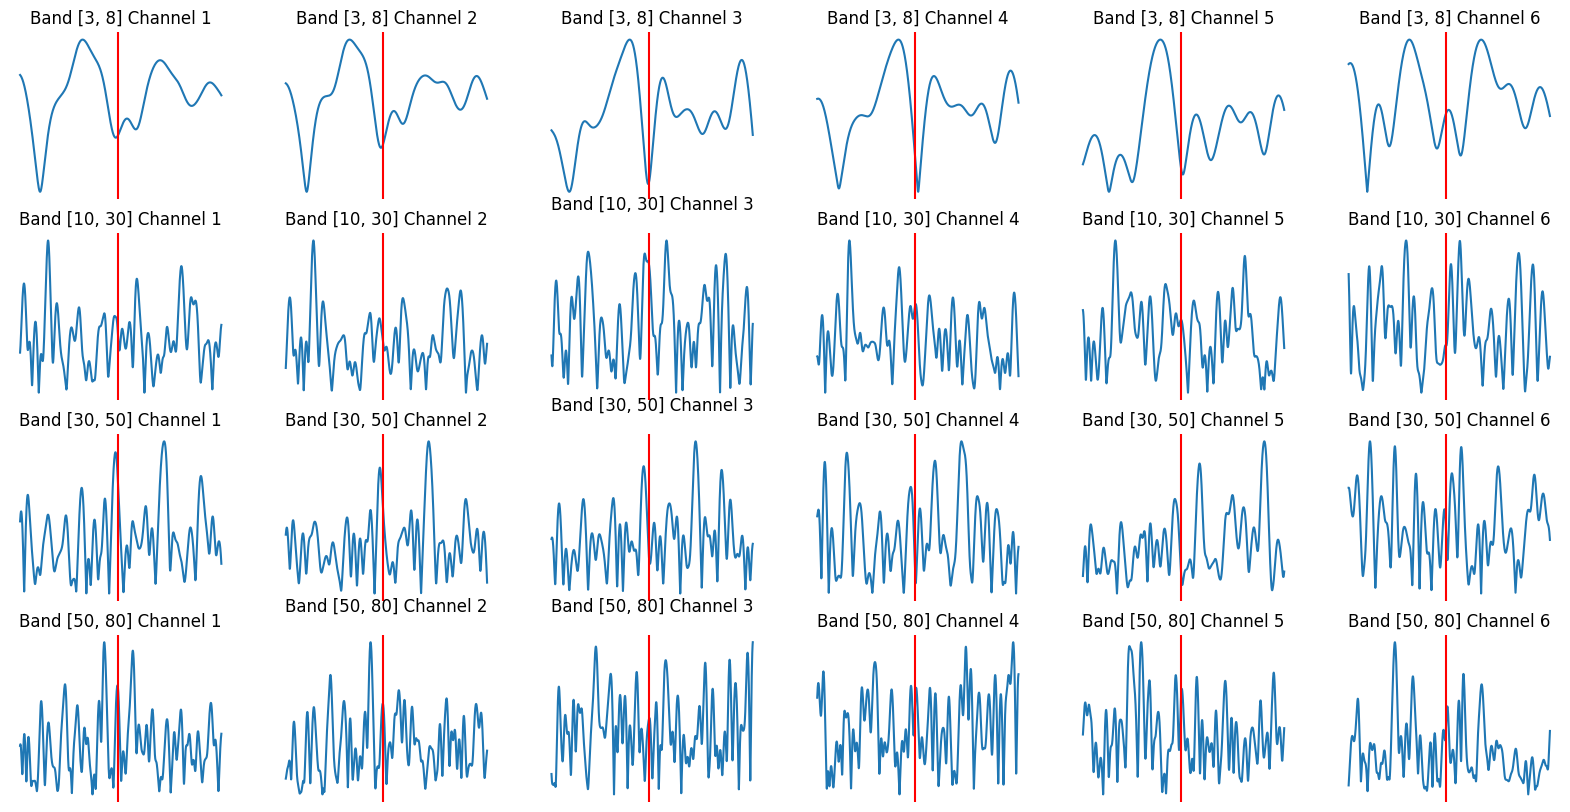

In [424]:
start = stim.iloc[3].start_time
near_idx = find_nearest_idx(master_time, [start]) # type: ignore
fig, axs = plt.subplots(4, 6, figsize=(20, 10))
for i in range(4):
    for j in range(6):
        axs[i, j].plot(bands[i, j].T[1700:4000])
        axs[i, j].axvline(near_idx-1700, c='r')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'Band {Wns[i]} Probe {j+1}')


In [224]:
bands = np.reshape(bands,(4*18, len(A_single)))
bands_z = (bands-np.mean(bands))/np.std(bands)

In [229]:
model = hmm.GaussianHMM(n_components=3, n_iter=1000, verbose=True, tol=0.1)
model.fit(bands_z.T[0:1000000])
preds= model.predict(bands_z.T[0:1000000])

         1 -10349747.55956448             +nan
         2 -7623107.79966874 +2726639.75989574
         3 -7296529.01459822 +326578.78507052
         4 -7175126.41429079 +121402.60030743
         5 -7099917.71504005  +75208.69925074
         6 -7052642.22366395  +47275.49137611
         7 -7023848.31746787  +28793.90619607
         8 -7007192.12538878  +16656.19207909
         9 -6997916.97180224   +9275.15358654
        10 -6993056.09189801   +4860.87990423
        11 -6990434.25686717   +2621.83503084
        12 -6989072.70982493   +1361.54704225
        13 -6988337.58950982    +735.12031510
        14 -6987938.36347976    +399.22603006
        15 -6987719.65475767    +218.70872210
        16 -6987599.14702415    +120.50773351
        17 -6987533.74038948     +65.40663467
        18 -6987498.52076636     +35.21962312
        19 -6987479.77803779     +18.74272857
        20 -6987469.65521365     +10.12282413
        21 -6987463.96533965      +5.68987400
        22 -6987460.59802311    

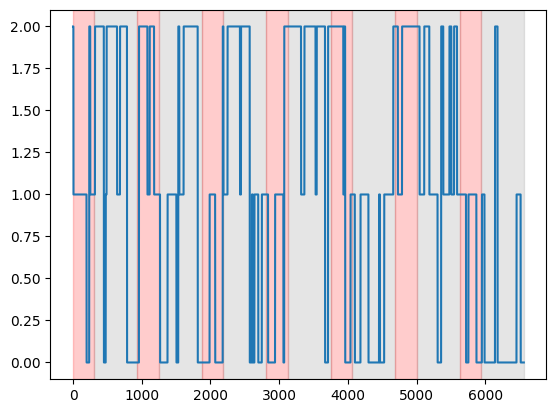

In [230]:
plot(preds,7)

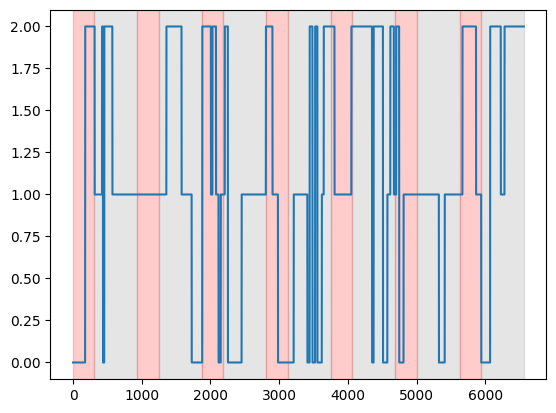

In [189]:
plot(preds,7)

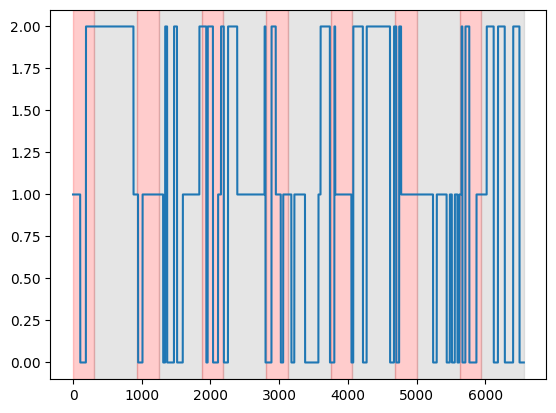

In [179]:
plot(preds,7) # global z-scoring

##### Hidden state distribution

26.51665497698943


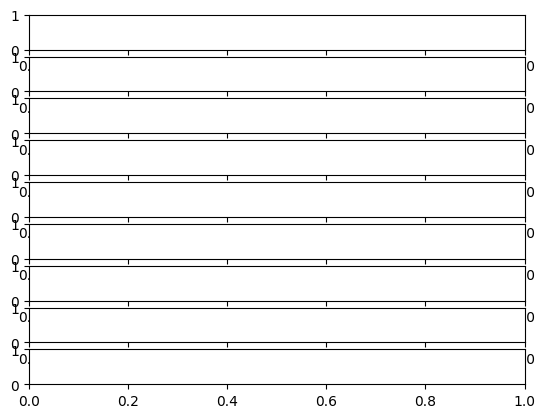

In [214]:
start_time = stim.iloc[0].start_time
fig, axs = plt.subplots(len(imgs),1)
for idx, img in enumerate(imgs):
    img_time = stim[stim['image_name']==img].start_time.values - start_time

#### signal power at onset

In [382]:
img = imgs[3] # target image
img_time = stim[stim['image_name']==img].start_time.values
A_temp = lfpA_copy[:,47]
bands = np.zeros((4, len(A_temp))) # 4 bands, 400k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
for i, Wn in enumerate(Wns):
    b, a = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='ba') # butterworth
    all_channels_ff = filtfilt(b, a, A_temp)
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env)
    bands[i] = all_channels_env_abs
    #bands[i] = all_channels_ff

In [380]:
onsets = find_nearest_idx(master_time, img_time[0:100])

In [383]:
powers = np.zeros([int(750/0.8), len(Wns)])
for idx, i in enumerate(range(int(-250/0.8), int(500/0.8))):
    energies = (bands[:, onsets+i] ** 2 + bands[:, onsets+i+1] ** 2) * 0.4
    power = energies / 0.8
    powers[idx] = np.mean(power, axis=1)

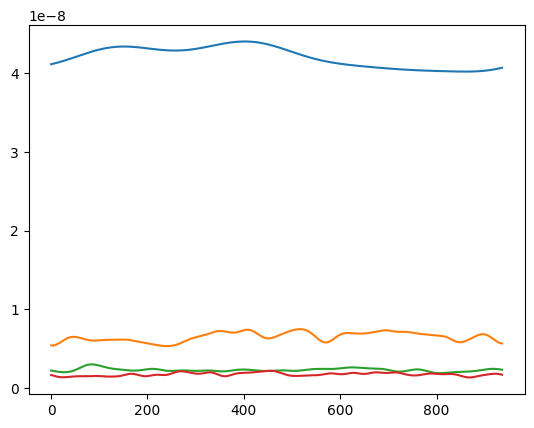

In [386]:
plt.plot(powers.T[0])
plt.plot(powers.T[1])
plt.plot(powers.T[2])
plt.plot(powers.T[3])

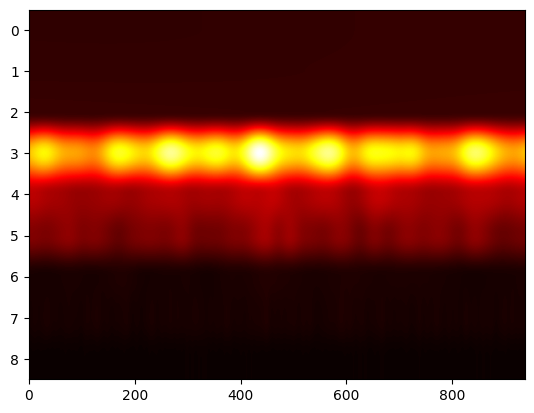

In [376]:
plt.imshow(powers.T, aspect='auto', cmap='hot')